<a href="https://colab.research.google.com/github/eljimenezj/CM0891-Aprendizaje-Automatico-/blob/master/Ingenieria_Caracteristicas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ingeniería de caracteristicas en Python

Este libro contiene un estudio de ingeniería de caracteristicas utilizando Python. Esto hace parte del curso de aprendizaje de maquinas de la Maestria de ciencia de datos.

Los integrantes de este trabajo:

* Santiago Echeverry Calderon
* Edgar Leandro Jimenez Jaimes

Vamos a instalar las librerias necesarias para la ejecución de este libro

In [0]:
#!pip install featuretools

Realizamos la importación de las librerias a utilizar

In [0]:
import pandas as pd
import numpy as np
import featuretools as ft
from featuretools.primitives import *
from featuretools.variable_types import Numeric
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing  import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
#warnings.filterwarnings('ignore')


Realizamos la carga del data set a utilizar:

El conjunto de datos a utilizar es Heart disease prediction, este es un dataset de un estudio cardiovascular en curso en los residentes de la ciudad de Framingham, Massachusetts. 

El objetivo de la clasificación es predecir si el paciente tiene 10 años de riesgo de enfermedad coronaria en el futuro. El conjunto de datos proporciona la información del paciente. Incluye más de 4,000 registros y 15 atributos.  Existen factores de riesgo demográficos, conductuales y médicos.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv('/content/drive/My Drive/CM0891-Aprendizaje-Automatico/Datasets/Heart disease prediction.csv')

Realizamos una pequeña revision de los datos que acabamos de importar

In [0]:
print(df.columns.values)

['male' 'age' 'education' 'currentSmoker' 'cigsPerDay' 'BPMeds'
 'prevalentStroke' 'prevalentHyp' 'diabetes' 'totChol' 'sysBP' 'diaBP'
 'BMI' 'heartRate' 'glucose' 'TenYearCHD']


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
male               4238 non-null int64
age                4238 non-null int64
education          4133 non-null float64
currentSmoker      4238 non-null int64
cigsPerDay         4209 non-null float64
BPMeds             4185 non-null float64
prevalentStroke    4238 non-null int64
prevalentHyp       4238 non-null int64
diabetes           4238 non-null int64
totChol            4188 non-null float64
sysBP              4238 non-null float64
diaBP              4238 non-null float64
BMI                4219 non-null float64
heartRate          4237 non-null float64
glucose            3850 non-null float64
TenYearCHD         4238 non-null int64
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


In [0]:
df.head(5)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [0]:
df.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4238.000000,4238.000000,4133.000000,4238.000000,4209.000000,4185.000000,4238.000000,4238.000000,4238.000000,4188.000000,4238.000000,4238.000000,4219.000000,4237.000000,3850.000000,4238.000000
mean,0.429212,49.584946,1.978950,0.494101,9.003089,0.029630,0.005899,0.310524,0.025720,236.721585,132.352407,82.893464,25.802008,75.878924,81.966753,0.151958
std,0.495022,8.572160,1.019791,0.500024,11.920094,0.169584,0.076587,0.462763,0.158316,44.590334,22.038097,11.910850,4.080111,12.026596,23.959998,0.359023
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,89.875000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


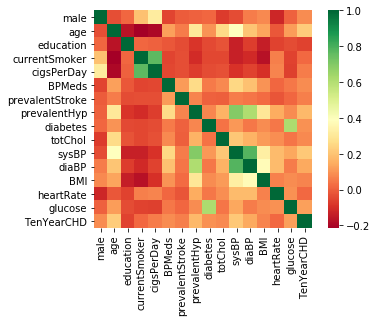

In [0]:
sns.heatmap(df.corr(), square=True, cmap='RdYlGn') 

Vamos a revisar la calidad de los datos

In [0]:
# Revisamos cuantos NA tiene la información
df.isna().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [0]:
# Vamos a retirar los registros nulos para este caso

# Tamaño inicial del dataset
df.shape

(4238, 16)

In [0]:
# Eliminamos los registros con NA
df = df.dropna()

In [0]:
# Tamaño luego de retirar registros con NA
df.shape

(3656, 16)

# Ingenieria de caracteristicas utilizando libreria

In [0]:
# Resetear el indice despues del borrado de los missing values
df2 = df.reset_index(drop=True)
df2.reset_index(inplace=True)
df2

#### Creación de la entidad para generación de nuevos atributos


In [0]:
es = ft.EntitySet(id = 'heart_disease_data')

es = es.entity_from_dataframe(entity_id = 'df2', dataframe = df2.drop(['TenYearCHD'], axis=1),
                              variable_types = 
                              {
                                  'male': ft.variable_types.Boolean,
                                  'age': ft.variable_types.Numeric,
                                  'education': ft.variable_types.Ordinal,
                                  'currentSmoker': ft.variable_types.Boolean,
                                  'cigsPerDay': ft.variable_types.Numeric,
                                  'BPMeds': ft.variable_types.Boolean,
                                  'prevalentStroke': ft.variable_types.Boolean,
                                  'prevalentHyp': ft.variable_types.Boolean,
                                  'diabetes': ft.variable_types.Boolean,
                                  'totChol': ft.variable_types.Numeric,
                                  'sysBP': ft.variable_types.Numeric,
                                  'diaBP': ft.variable_types.Numeric,
                                  'BMI': ft.variable_types.Numeric,
                                  'heartRate': ft.variable_types.Numeric,
                                  'glucose': ft.variable_types.Numeric,
                              }, 
                              index = 'index')

es

Entityset: heart_disease_data
  Entities:
    df2 [Rows: 3656, Columns: 16]
  Relationships:
    No relationships

In [0]:
es = es.normalize_entity(base_entity_id='df2', new_entity_id='male', index='male')
es = es.normalize_entity(base_entity_id='df2', new_entity_id='education', index='education')
es = es.normalize_entity(base_entity_id='df2', new_entity_id='currentSmoker', index='currentSmoker')
es = es.normalize_entity(base_entity_id='df2', new_entity_id='diabetes', index='diabetes')
es

2020-02-20 01:24:07,606 featuretools.entityset - WARNING    Not adding duplicate relationship: <Relationship: df2.currentSmoker -> currentSmoker.currentSmoker>


Entityset: heart_disease_data
  Entities:
    df2 [Rows: 3656, Columns: 16]
    currentSmoker [Rows: 2, Columns: 1]
    male [Rows: 2, Columns: 1]
    education [Rows: 4, Columns: 1]
    diabetes [Rows: 2, Columns: 1]
  Relationships:
    df2.currentSmoker -> currentSmoker.currentSmoker
    df2.male -> male.male
    df2.education -> education.education
    df2.diabetes -> diabetes.diabetes

In [0]:
features, feature_names = ft.dfs(entityset = es, 
                                 target_entity = 'df2', 
                                 max_depth = 2)

In [0]:
features.head()

In [0]:
len(feature_names)

247

In [0]:
feature_names

In [0]:
features[features['age'] > 30][["diabetes.MEAN(df2.age)","age","diabetes"]].head()

,diabetes.MEAN(df2.age),age,diabetes
index,,,
0,49.401743,39,0
1,49.401743,46,0
2,49.401743,48,0
3,49.401743,61,0
4,49.401743,46,0


#### Selección de atributos según colinealidad


In [0]:
# Threshold for removing correlated variables
threshold = 0.95

# Absolute value correlation matrix
corr_matrix = features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head(50)

In [0]:
# Select columns with correlations above threshold
collinear_features = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d features to remove.' % (len(collinear_features)))

There are 193 features to remove.


In [0]:
features_filtered = features.drop(columns = collinear_features)

print('The number of features that passed the collinearity threshold: ', features_filtered.shape[1])

The number of features that passed the collinearity threshold:  54


In [0]:
features_filtered.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,currentSmoker.MIN(df2.glucose),currentSmoker.NUM_UNIQUE(df2.male),currentSmoker.NUM_UNIQUE(df2.education),currentSmoker.NUM_UNIQUE(df2.diabetes),currentSmoker.MODE(df2.education),currentSmoker.MODE(df2.diabetes),male.MAX(df2.glucose),male.MIN(df2.cigsPerDay),male.MIN(df2.sysBP),male.MIN(df2.glucose),male.NUM_UNIQUE(df2.education),male.NUM_UNIQUE(df2.currentSmoker),male.NUM_UNIQUE(df2.diabetes),male.MODE(df2.education),male.MODE(df2.diabetes),education.STD(df2.age),education.STD(df2.cigsPerDay),education.STD(df2.totChol),education.STD(df2.glucose),education.MAX(df2.age),education.MAX(df2.cigsPerDay),education.MAX(df2.totChol),education.MAX(df2.glucose),education.SKEW(df2.age),education.SKEW(df2.cigsPerDay),education.SKEW(df2.heartRate),education.MIN(df2.cigsPerDay),education.MIN(df2.glucose),education.NUM_UNIQUE(df2.male),education.NUM_UNIQUE(df2.currentSmoker),education.NUM_UNIQUE(df2.diabetes),education.MODE(df2.diabetes),diabetes.MIN(df2.cigsPerDay),diabetes.NUM_UNIQUE(df2.male),diabetes.NUM_UNIQUE(df2.education),diabetes.NUM_UNIQUE(df2.currentSmoker),diabetes.MODE(df2.male),diabetes.MODE(df2.education),diabetes.MODE(df2.currentSmoker)
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,40.0,2,4,2,1.0,0,394.0,0.0,83.5,40.0,4,2,2,1.0,0,8.285730,12.417844,40.351822,16.024154,67,60.0,382.0,183.0,0.418979,1.154373,0.378180,0.0,43.0,2,2,2,0,0.0,2,4,2,0,1.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,40.0,2,4,2,1.0,0,394.0,0.0,83.5,40.0,4,2,2,1.0,0,8.296487,11.817173,46.493689,22.116877,70,60.0,600.0,394.0,0.546940,1.046002,0.507869,0.0,40.0,2,2,2,0,0.0,2,4,2,0,1.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,40.0,2,4,2,1.0,0,394.0,0.0,83.5,40.0,4,2,2,1.0,0,8.414159,12.035009,43.073275,25.261233,69,60.0,432.0,386.0,-0.044619,1.341062,0.797690,0.0,40.0,2,2,2,0,0.0,2,4,2,0,1.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,40.0,2,4,2,1.0,0,394.0,0.0,83.5,40.0,4,2,2,1.0,0,8.136133,11.369730,44.637853,27.760985,69,70.0,464.0,394.0,0.305326,1.358624,0.831521,0.0,44.0,2,2,2,0,0.0,2,4,2,0,1.0,0
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,40.0,2,4,2,1.0,0,394.0,0.0,83.5,40.0,4,2,2,1.0,0,8.136133,11.369730,44.637853,27.760985,69,70.0,464.0,394.0,0.305326,1.358624,0.831521,0.0,44.0,2,2,2,0,0.0,2,4,2,0,1.0,0


#### Detectar las características más relevantes utilizando modelos lineales penalizados con la norma L1

In [0]:
features_positive = features_filtered.loc[:, features_filtered.ge(0).all()]

features_positive.shape

(3656, 53)

In [0]:
features_filtered.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,currentSmoker.MIN(df2.glucose),currentSmoker.NUM_UNIQUE(df2.male),currentSmoker.NUM_UNIQUE(df2.education),currentSmoker.NUM_UNIQUE(df2.diabetes),currentSmoker.MODE(df2.education),currentSmoker.MODE(df2.diabetes),male.MAX(df2.glucose),male.MIN(df2.cigsPerDay),male.MIN(df2.sysBP),male.MIN(df2.glucose),male.NUM_UNIQUE(df2.education),male.NUM_UNIQUE(df2.currentSmoker),male.NUM_UNIQUE(df2.diabetes),male.MODE(df2.education),male.MODE(df2.diabetes),education.STD(df2.age),education.STD(df2.cigsPerDay),education.STD(df2.totChol),education.STD(df2.glucose),education.MAX(df2.age),education.MAX(df2.cigsPerDay),education.MAX(df2.totChol),education.MAX(df2.glucose),education.SKEW(df2.age),education.SKEW(df2.cigsPerDay),education.SKEW(df2.heartRate),education.MIN(df2.cigsPerDay),education.MIN(df2.glucose),education.NUM_UNIQUE(df2.male),education.NUM_UNIQUE(df2.currentSmoker),education.NUM_UNIQUE(df2.diabetes),education.MODE(df2.diabetes),diabetes.MIN(df2.cigsPerDay),diabetes.NUM_UNIQUE(df2.male),diabetes.NUM_UNIQUE(df2.education),diabetes.NUM_UNIQUE(df2.currentSmoker),diabetes.MODE(df2.male),diabetes.MODE(df2.education),diabetes.MODE(df2.currentSmoker)
count,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.0,3656.0,3656.0,3656.0,3656.0,3656.0,3656.0,3656.0,3656.0,3656.0,3656.0,3656.0,3656.0,3656.0,3656.0,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.0,3656.000000,3656.0,3656.0,3656.0,3656.0,3656.0,3656.0,3656.0,3656.0,3656.0,3656.0,3656.0
mean,0.443654,49.557440,1.979759,0.489059,9.022155,0.030361,0.005744,0.311543,0.027079,236.873085,132.368025,82.912062,25.784185,75.730580,81.856127,40.0,2.0,4.0,2.0,1.0,0.0,394.0,0.0,83.5,40.0,4.0,2.0,2.0,1.0,0.0,8.317779,11.903429,44.047792,23.659928,69.069748,61.657549,482.112144,366.248085,0.245172,1.233516,0.667481,0.0,41.010120,2.0,2.0,2.0,0.0,0.0,2.0,4.0,2.0,0.0,1.0,0.0
std,0.496883,8.561133,1.022657,0.499949,11.918869,0.171602,0.075581,0.463187,0.162335,44.096223,22.092444,11.974825,4.065913,11.982952,23.910128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098002,0.295501,1.958887,3.365129,0.871374,3.719114,80.306564,66.399096,0.258049,0.136897,0.170001,0.0,1.635166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.000000,83.500000,48.000000,15.540000,44.000000,40.000000,40.0,2.0,4.0,2.0,1.0,0.0,394.0,0.0,83.5,40.0,4.0,2.0,2.0,1.0,0.0,8.136133,11.369730,40.351822,16.024154,67.000000,60.000000,382.000000,183.000000,-0.044619,1.046002,0.378180,0.0,40.000000,2.0,2.0,2.0,0.0,0.0,2.0,4.0,2.0,0.0,1.0,0.0
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.080000,68.000000,71.000000,40.0,2.0,4.0,2.0,1.0,0.0,394.0,0.0,83.5,40.0,4.0,2.0,2.0,1.0,0.0,8.285730,11.817173,43.073275,22.116877,69.000000,60.000000,432.000000,386.000000,-0.044619,1.046002,0.507869,0.0,40.000000,2.0,2.0,2.0,0.0,0.0,2.0,4.0,2.0,0.0,1.0,0.0
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.380000,75.000000,78.000000,40.0,2.0,4.0,2.0,1.0,0.0,394.0,0.0,83.5,40.0,4.0,2.0,2.0,1.0,0.0,8.296487,12.035009,43.073275,25.261233,69.000000,60.000000,432.000000,386.000000,0.305326,1.341062,0.797690,0.0,40.000000,2.0,2.0,2.0,0.0,0.0,2.0,4.0,2.0,0.0,1.0,0.0
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.250000,144.000000,90.000000,28.040000,82.000000,87.000000,40.0,2.0,4.0,2.0,1.0,0.0,394.0,0.0,83.5,40.0,4.0,2.0,2.0,1.0,0.0,8.414159,12.035009,46.493689,25.261233,70.000000,60.000000,600.000000,394.000000,0.546940,1.341062

In [0]:
y = df2['TenYearCHD'].values
X = features_positive

test_size = 0.2
scaler = MinMaxScaler()

scaled_X = scaler.fit_transform(X)

df_scaled_X = pd.DataFrame(scaled_X)

train_X, test_X, train_y, test_y = train_test_split(df_scaled_X,y, test_size = test_size, random_state=42, stratify=y)

In [0]:
lsvc = LinearSVC(C=0.01, penalty="l1", 
                 max_iter = 20000,
                 dual=False).fit(train_X, train_y) 
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(train_X)
X_selected_df = pd.DataFrame(X_new, columns=[train_X.columns[i] for i in range(len(train_X.columns)) if model.get_support()[i]])
X_selected_df.shape

(2924, 6)

In [0]:
X_new_test = model.transform(test_X)
X_selected_df_test = pd.DataFrame(X_new_test, columns=[test_X.columns[i] for i in range(len(test_X.columns)) if model.get_support()[i]])
X_selected_df_test.shape

(732, 6)

In [0]:
print(train_X.shape)

X_new.shape

(2924, 53)


(2924, 6)

In [0]:
X_selected_df.head()

,0,1,2,7,32,36
0,0.0,0.894737,0.333333,0.0,1.000000,1.000000
1,1.0,0.184211,1.000000,0.0,0.000000,0.000000
2,1.0,0.657895,0.666667,0.0,0.697838,0.376147
3,1.0,0.473684,0.000000,0.0,0.443099,0.229358
4,0.0,0.342105,0.333333,0.0,1.000000,1.000000


In [0]:
X_o = df2.drop('TenYearCHD', 1)

#scaler = StandardScaler()
scaler = MinMaxScaler()
scaled = scaler.fit_transform(X_o)

train_X_o, test_X_o, train_y_o, test_y_o = train_test_split(scaled,y, test_size = test_size, random_state=42, stratify=y)

#### Modelos con variables originales

In [0]:
# Entrenamiento de Random Forest con variables originales
random_forest_o = RandomForestClassifier(n_estimators=1000,oob_score=True)
random_forest_o.fit(train_X_o, train_y)

y_pred_train_o = random_forest_o.predict(test_X_o)

print(classification_report(test_y, y_pred_train_o))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       620
           1       0.53      0.08      0.14       112

    accuracy                           0.85       732
   macro avg       0.69      0.53      0.53       732
weighted avg       0.81      0.85      0.80       732



In [0]:
# Entrenamiento de Regresion Logistica con variables originales
logreg_o = LogisticRegression()
logreg_o.fit(train_X_o, train_y)
y_pred_train_o = logreg_o.predict(test_X_o)
print(classification_report(test_y, y_pred_train_o))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       620
           1       0.76      0.12      0.20       112

    accuracy                           0.86       732
   macro avg       0.81      0.55      0.56       732
weighted avg       0.85      0.86      0.81       732



#### Modelos con variables nuevas

In [0]:
# Entrenamiento de Random Forest con nuevas variables
random_forest_n = RandomForestClassifier(n_estimators=2000,oob_score=True)
random_forest_n.fit(X_selected_df.values, train_y)

y_pred_train_n = random_forest_n.predict(X_selected_df_test.values)

print(classification_report(test_y, y_pred_train_n))

              precision    recall  f1-score   support

           0       0.86      0.98      0.91       620
           1       0.44      0.11      0.17       112

    accuracy                           0.84       732
   macro avg       0.65      0.54      0.54       732
weighted avg       0.79      0.84      0.80       732



In [0]:
# Entrenamiento de Regresion Logistica con nuevas variables
logreg_n = LogisticRegression()
logreg_n.fit(X_selected_df.values, train_y)
y_pred_train_n = logreg_n.predict(X_selected_df_test.values)
print(classification_report(test_y, y_pred_train_n))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       620
           1       0.50      0.01      0.02       112

    accuracy                           0.85       732
   macro avg       0.67      0.50      0.47       732
weighted avg       0.79      0.85      0.78       732



# Ingenieria de caracteristicas de manera manual

**Tareas**
* cambiar la profundiad del feature tool  
* estudiar clasification report  
* agregar todas las entidades de transformacion  
* probar con diferentes escaladores  
* probar diferentes escaladores y en difrentes momentos del modelo  
* probar un nuevo umbral de la correlacion


## Fuentes


https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering

https://www.kaggle.com/liananapalkova/automated-feature-engineering-for-titanic-dataset